# Setup

In [107]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
from graph_transformer import load_model, QueryKey, prepare, run, run_all
from pygio import load_dataset, pyg_to_gt
import graph_tool.all as gt
from einops import rearrange
import torch
import seaborn as sns
from callbacks import LogitAttribution, LogTrainingAttention
from matplotlib import colormaps as cm
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = load_dataset("cora", split="full", d_model=32, random_orthogonal_pos_init=False).to(device)
graph = pyg_to_gt(data)


Seed set to 123
/home/lcheng/.conda/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/lcheng/.conda/envs/rapids-24.12/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/fred/oz318/luhanc/gtinterp/graph_transformer.py:438: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions th

In [27]:
load = partial(load_model, device=device, n_heads=2, n_layers=2, dataset_name="cora", return_ckpt=True)

# Cora Data

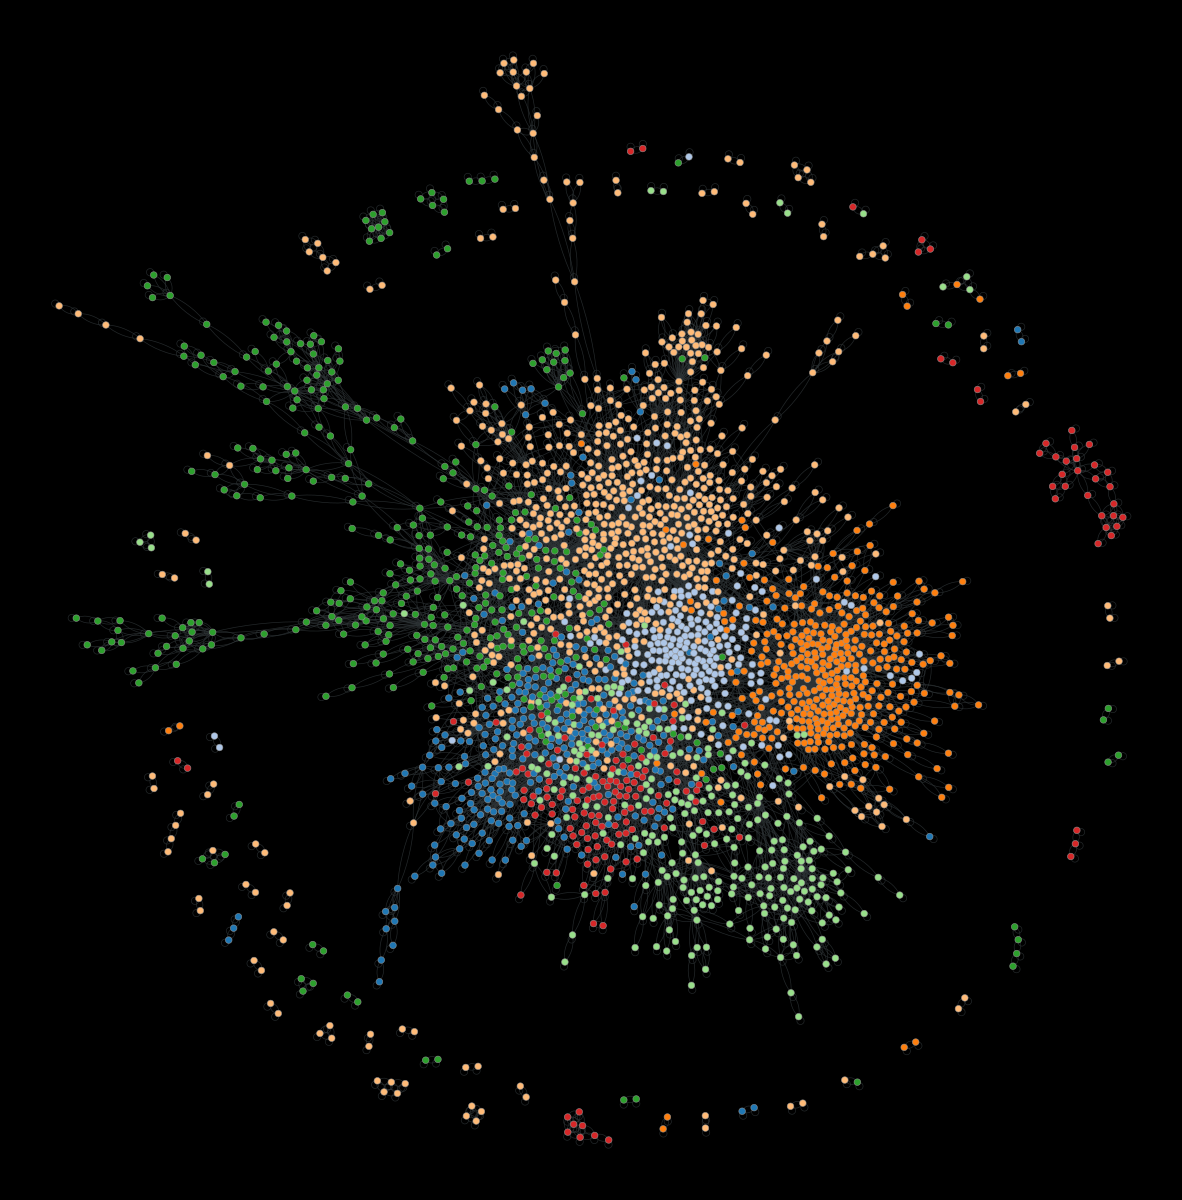

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f04ffe36690, at 0x7efebfce7560>

In [46]:
gt.graph_draw(graph, vertex_fill_color=graph.vp['y'], pos=graph.vp['pos'], bg_color=(0, 0, 0, 1), inline=True)

# Logit Lens

In [28]:
model, ckpt = load(masked=True, random_orthogonal_pos_init=False)

Seed set to 123
/home/lcheng/.conda/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/lcheng/.conda/envs/rapids-24.12/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/fred/oz318/luhanc/gtinterp/graph_transformer.py:438: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions th

In [11]:
logit_attr = LogitAttribution()
logit_attr.compute(model)
logit_lens = logit_attr._plot_average_logits()

Tried to stack head results when they weren't cached. Computing head results now


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Logit lens makes prediction from some intermediate representation in the transformer network. Since our output vocab is small we can take a snap shot of residual stream and project it to all pair logit difference directions. Making a (n_class, n_class) heatmap as following. We can see from the figure below, that layer 0 head 0 seems to really like the class 0. It push everything it seems towards class 0. And layer 1 head 0 push everything away from class 6. 

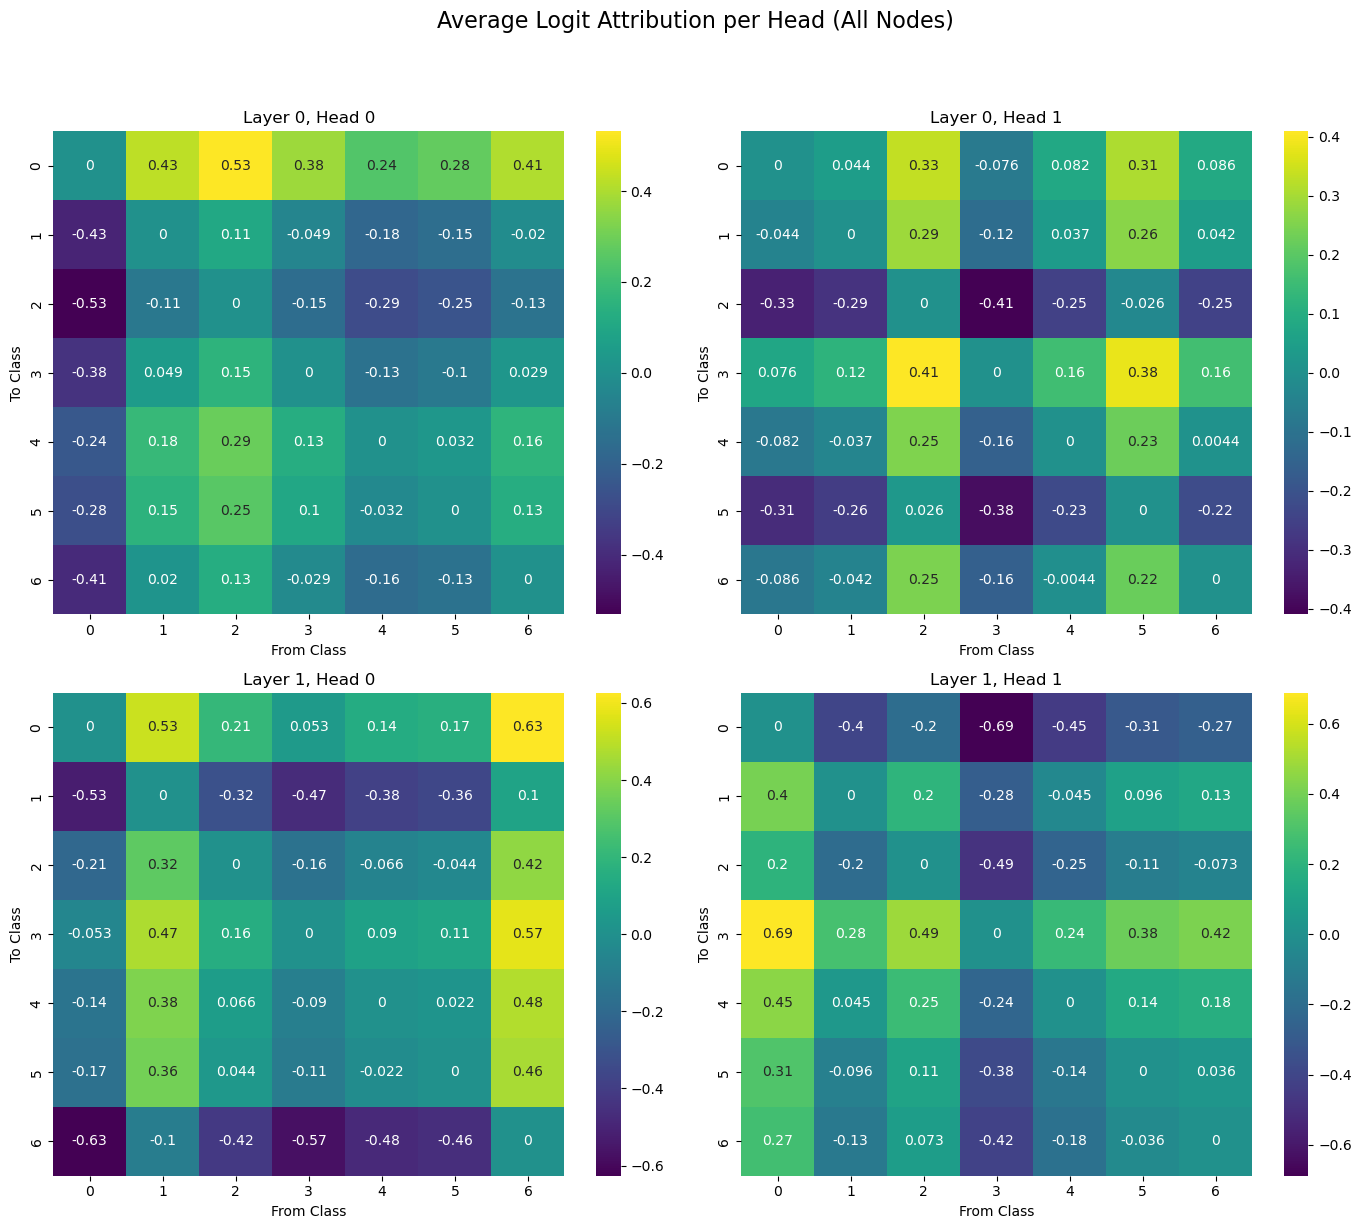

In [12]:
logit_lens['avg_logits_per_layer_head']

And summing up all 4 heads, we get the following plot

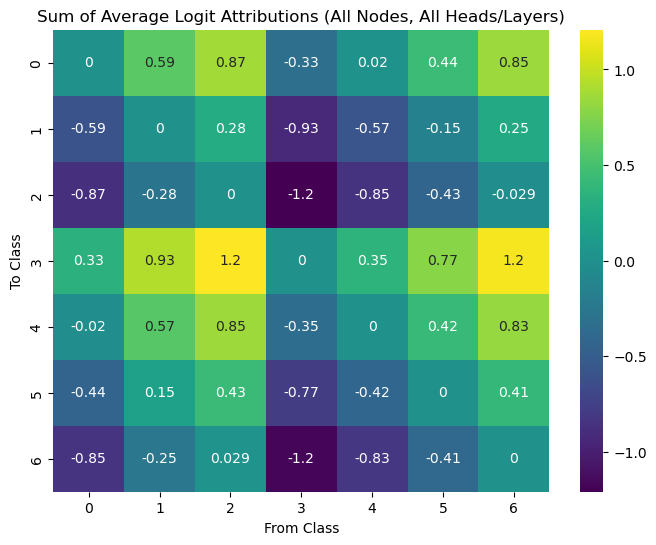

In [13]:
logit_lens['avg_logits_sum_all']

We can see the heatmap has this blocky structure, where class 0, 1, 2 forms one block and class 3,4,5,6 form another block. Within each block, the upper triangle is always positive while the lower triangle is always negative. So within each block, the model always tries to predict earlier class. 

# Attention During Training

In [37]:
def plot_attention(model, ckpt):
    attention_callback = LogTrainingAttention(mask=data.train_mask)
    attention_callback.load_state_dict(ckpt['callbacks']['LogTrainingAttention'])
    attention_callback.compute(model)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
    attention_callback.plot(axes_dict={f"training_attention/{i}": ax for i, ax in enumerate(axes)})
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    return fig

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

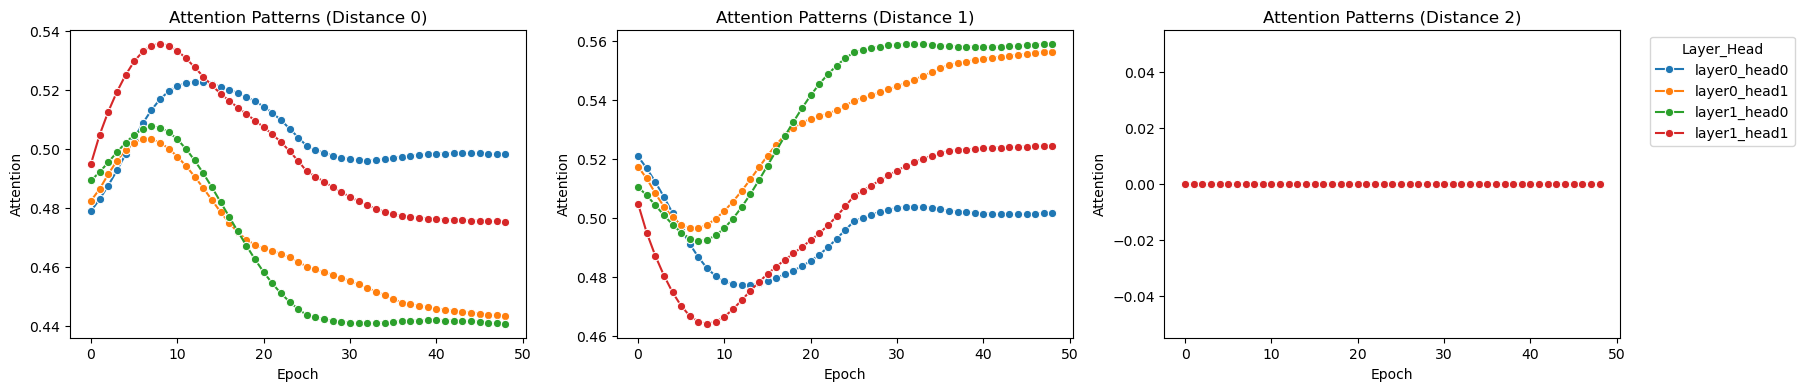

In [41]:
plot_attention(model, ckpt)

In the figure above, we plot the attention payed from each query node to k-hop key nodes. For example, the leftmost axis shows the self-attention (distance 0). The middle figure shows all attention payed to nodes that are one hop away and the rightmost figure shows the attention payed for all 2-hop neighbors

# Singular Scores of Positional Encoding

In [55]:
lap_qk = QueryKey(model)
rand_model, rand_ckpt = load(masked=True, random_orthogonal_pos_init=True)
rand_qk = QueryKey(rand_model)

Seed set to 123
/home/lcheng/.conda/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/lcheng/.conda/envs/rapids-24.12/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/fred/oz318/luhanc/gtinterp/graph_transformer.py:438: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions th

<IPython.core.display.Javascript object>

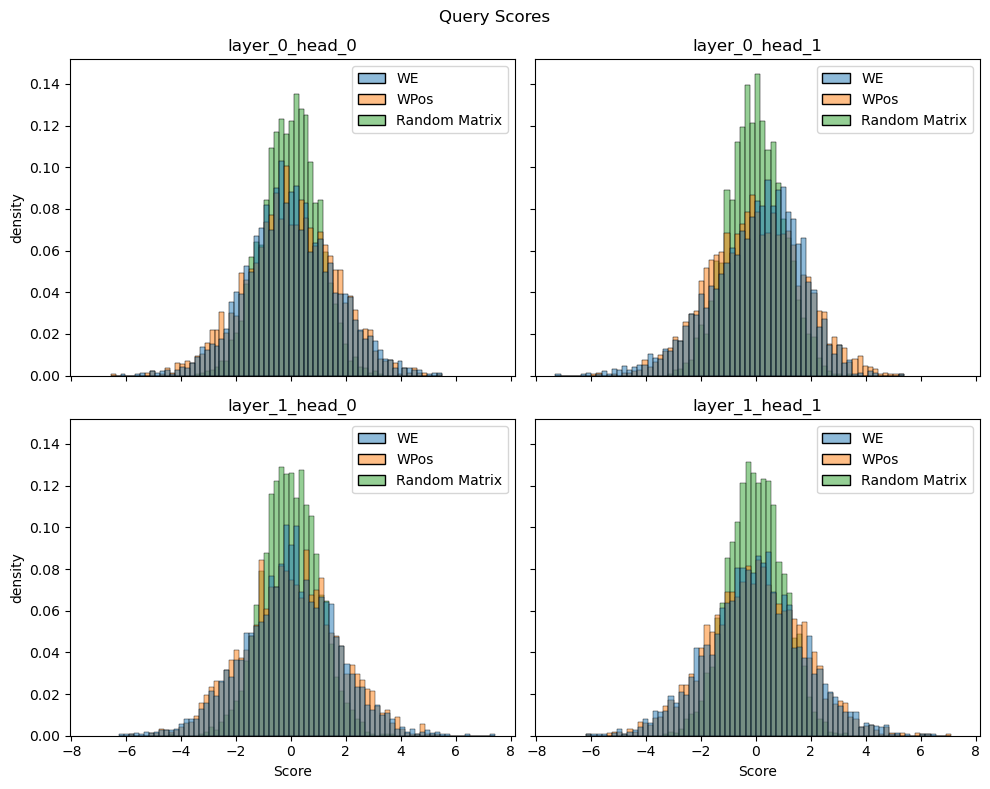

In [56]:
rand_qk = QueryKey(rand_model)
rand_qk.plot_hist(qk=0, k=0, add_random_matrix=True)

<IPython.core.display.Javascript object>

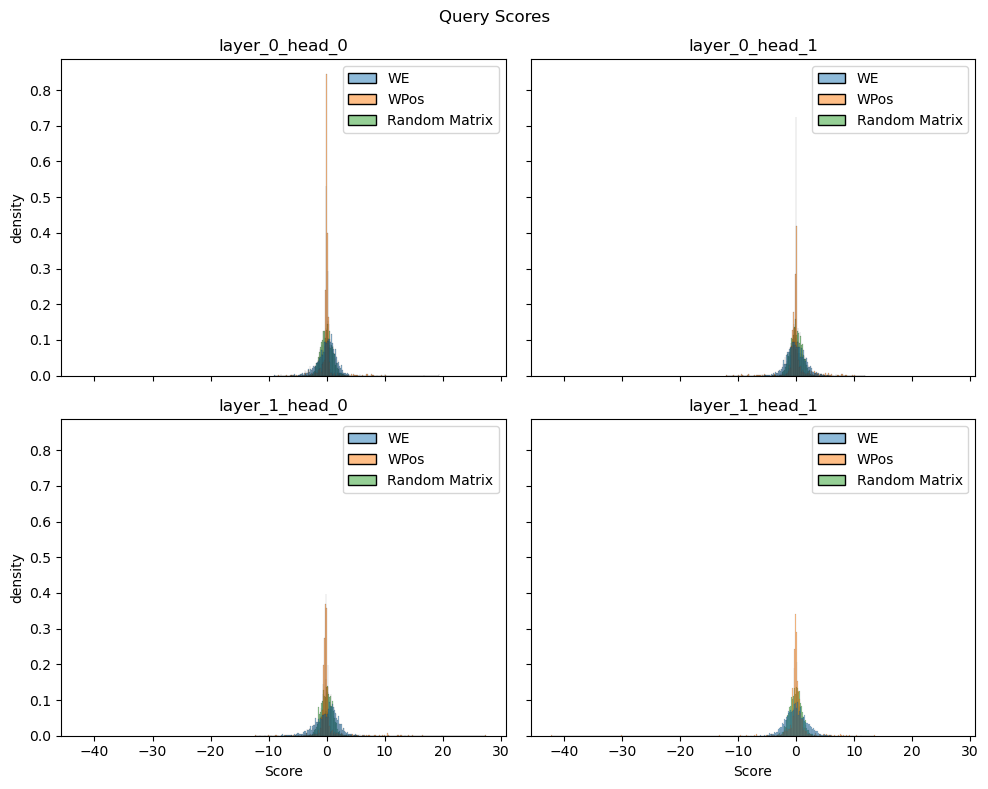

In [57]:
lap_qk = QueryKey(model)
lap_qk.plot_hist(qk=0, k=0, add_random_matrix=True)

# Outlier

If we checkout what are the long tails shown in the previous histogram, we can see that it basically detects the small periperal communities. The following plot highlights nodes that are 2 sigma away from mean for query scores of laplacian positional encoding. 

In [85]:
def draw_upper_outlier(laplacian_encoding, masked):
    model, _ = load(masked=masked, random_orthogonal_pos_init=not laplacian_encoding)
    qk = QueryKey(model)
    return qk.draw_upper_outlier(qk=0, ep=1, k=0, layer=0, head=0)

Seed set to 123
/home/lcheng/.conda/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/lcheng/.conda/envs/rapids-24.12/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/fred/oz318/luhanc/gtinterp/graph_transformer.py:438: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions th

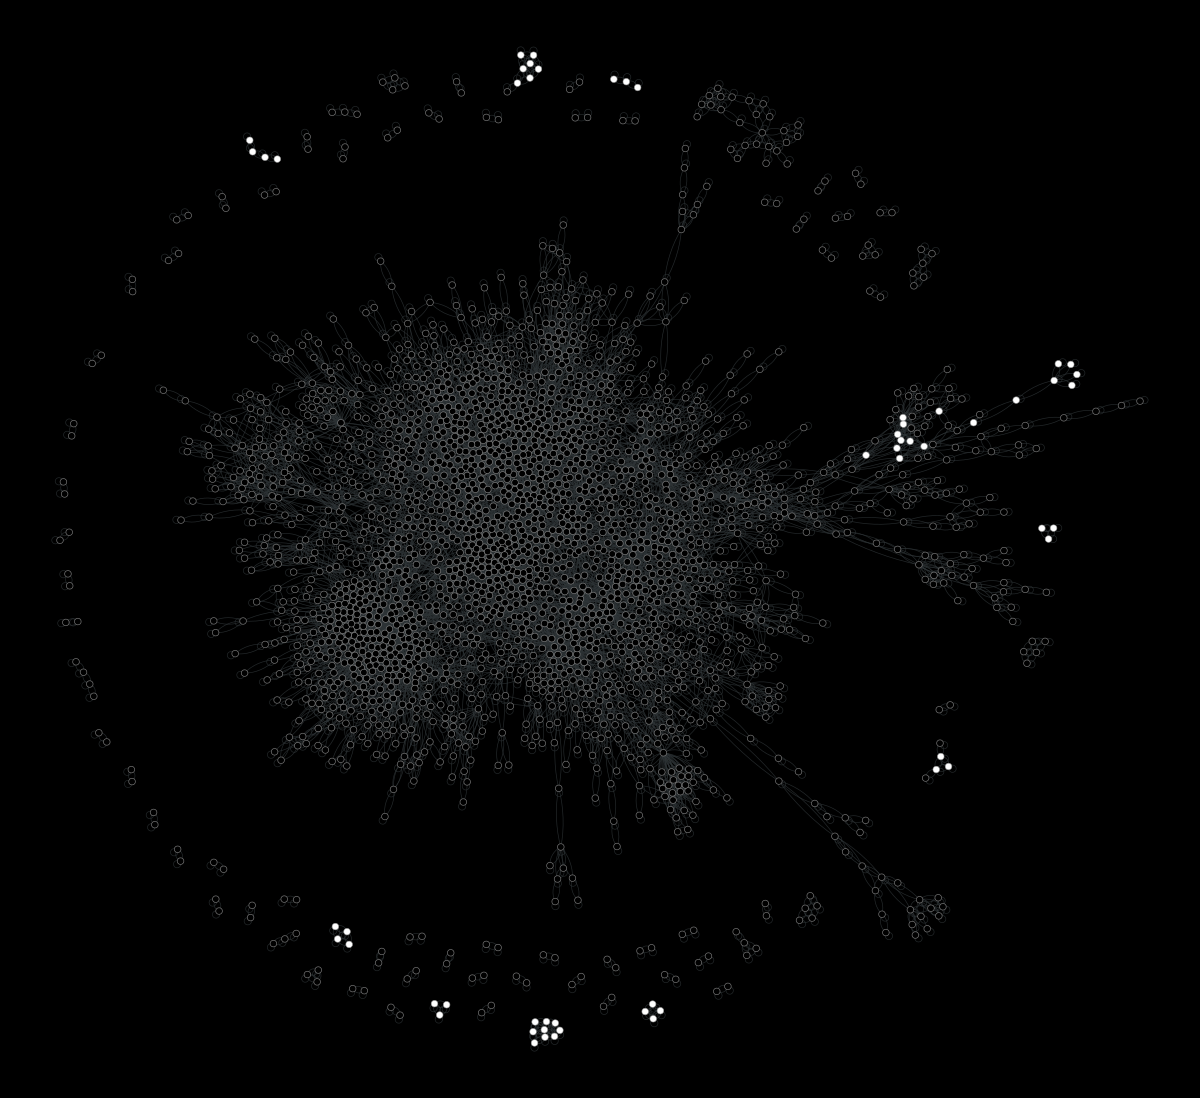

<VertexPropertyMap object with value type 'vector<double>', for a non-existent graph, at 0x7f019138bf20>

In [86]:
draw_upper_outlier(laplacian_encoding=True, masked=True)

In contrary, if we are looking at transformers that does not use graph inductive bias (no attention masking, random positional encoding). The following shows nodes that are also 2 sigma away. 

Seed set to 123
/home/lcheng/.conda/envs/rapids-24.12/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/lcheng/.conda/envs/rapids-24.12/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/fred/oz318/luhanc/gtinterp/graph_transformer.py:438: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions th

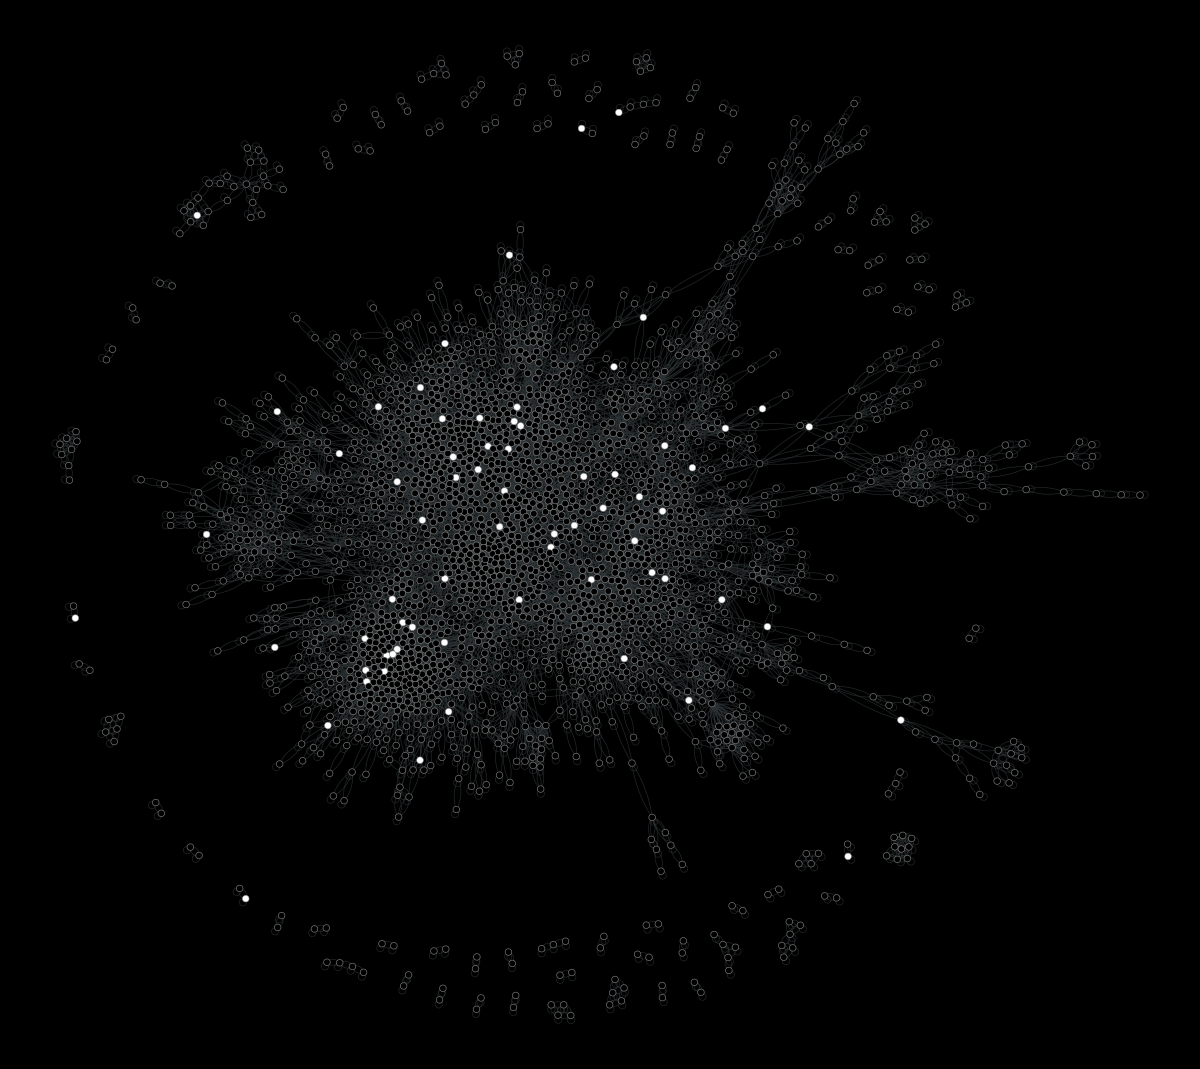

<VertexPropertyMap object with value type 'vector<double>', for a non-existent graph, at 0x7f01912cad80>

In [87]:
draw_upper_outlier(laplacian_encoding=False, masked=False)

Interestingly, the model that just have non-neighbor masked out (equivalent to classic GAT with random positional encoding) does not exhibit this behaviour. But the model with laplacian positional encoding without masking (equivalent to a normal language transformer with graph based attention mask) shows their singular scores detect small peripheral communities.  

Seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


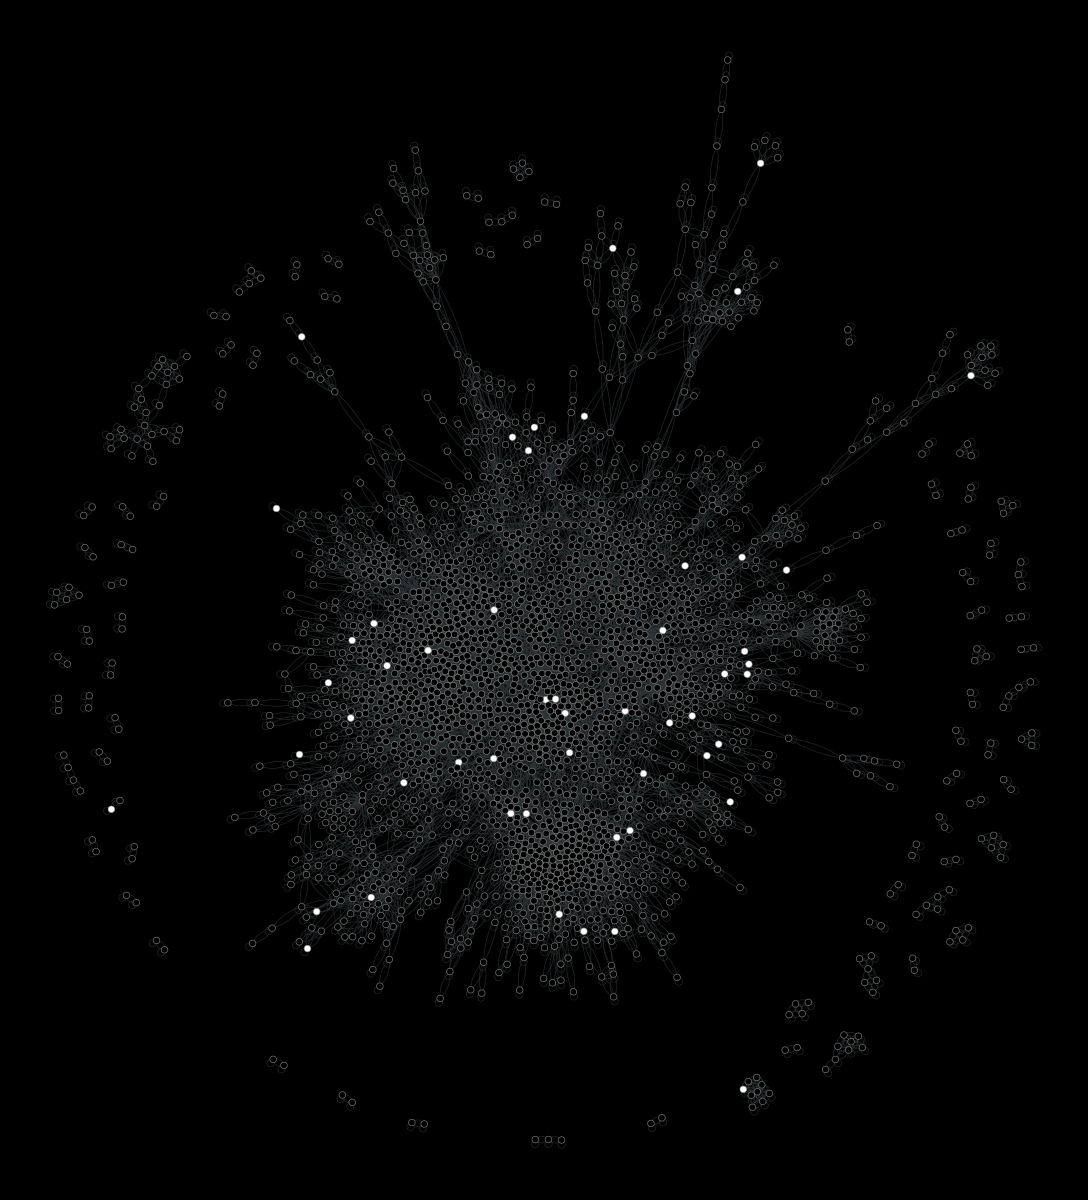

<VertexPropertyMap object with value type 'vector<double>', for a non-existent graph, at 0x7f0190ec4a70>

In [ ]:
draw_upper_outlier(laplacian_encoding=False, masked=True)

Seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


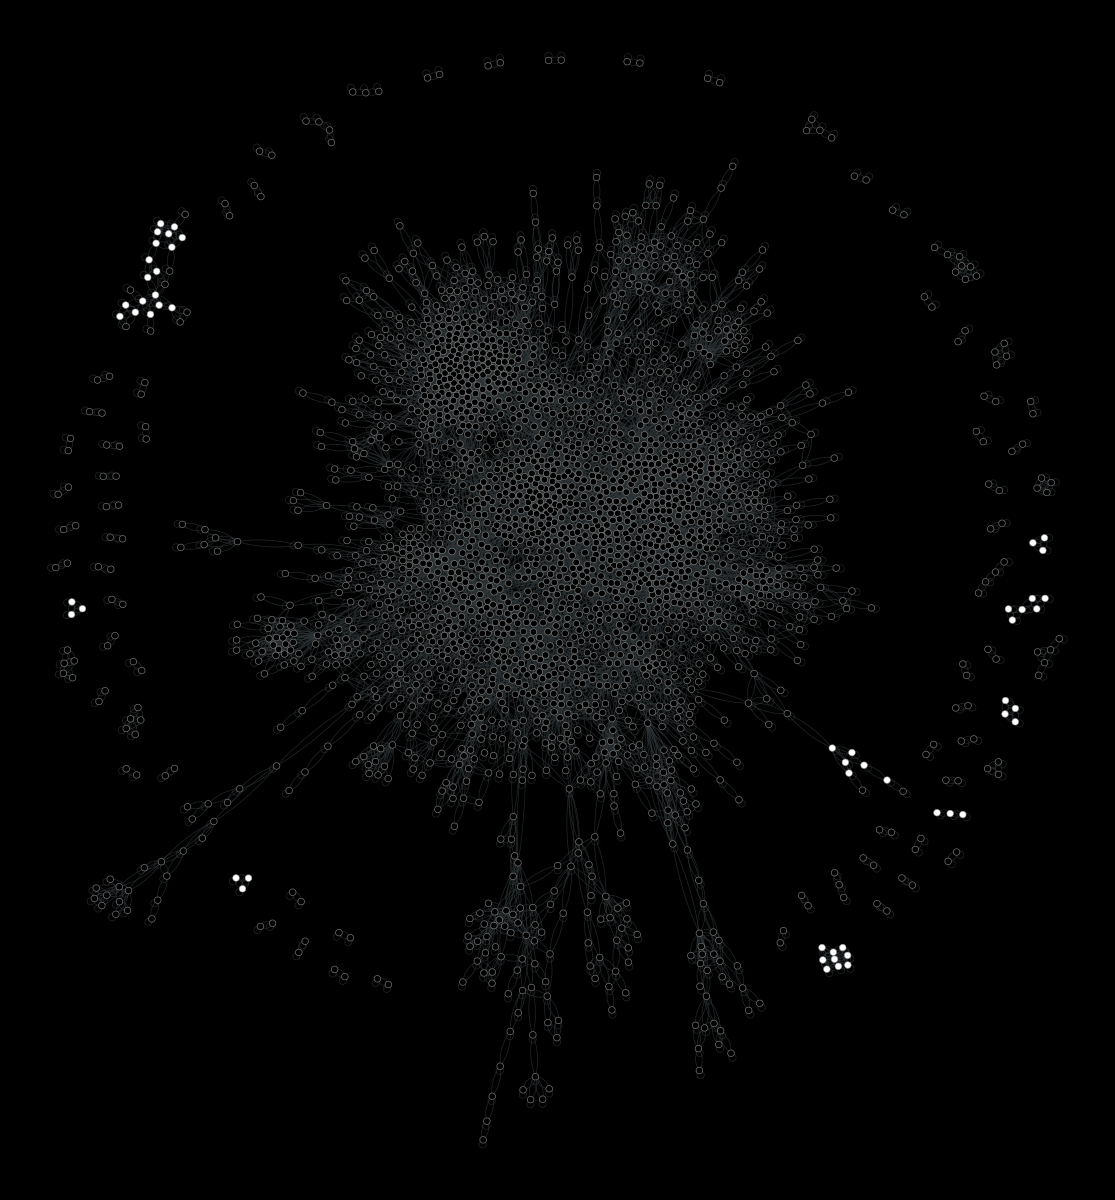

<VertexPropertyMap object with value type 'vector<double>', for a non-existent graph, at 0x7f0190cdcb90>

In [91]:
draw_upper_outlier(laplacian_encoding=True, masked=False)

The CDF plot below shows that the singular score outliers seems to be differentiating class 4 on the high end and class 6 on the low end. 

<IPython.core.display.Javascript object>

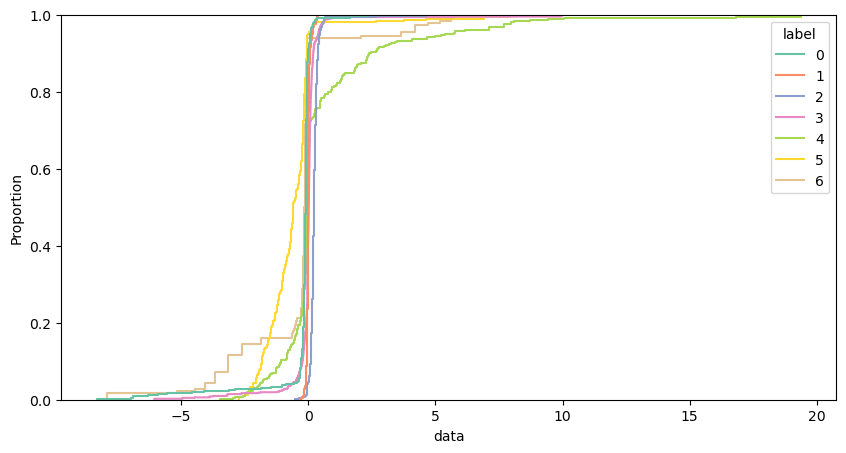

In [138]:
df = pd.DataFrame({"data": lap_qk.scores[0, 1, 0, 0, :, 0].cpu().numpy(), "label": data.y.cpu().numpy()})
fig, ax = plt.subplots(figsize=(10, 5))
sns.ecdfplot(df, x="data", hue="label", ax=ax, palette='Set2')
fig